In [2]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import SimpleITK as sitk
import torch
from torchvision import transforms as xfms

from model import UNet

/root/miniconda3/envs/med/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
HU_CLIP = [-900, 100]
IMG_SIZE = 512
NET_SIZE = 448
MEAN = 0.36
STD = 0.42
XFM_COMP = xfms.Compose([
    xfms.ToTensor(),
    xfms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    xfms.CenterCrop((NET_SIZE, NET_SIZE)),
    xfms.Normalize(MEAN, STD)
])

In [22]:
def preprocess(patientDicomPath, xfmComp=XFM_COMP):
    # Load all the DICOM files from a single folder into a list of 3D images and return the numpy array by simpleITK
    # reader = sitk.ImageSeriesReader()
    # dicom_names = reader.GetGDCMSeriesFileNames(patientDicomPath)
    # reader.SetFileNames(dicom_names)
    # img_itk = reader.Execute()
    # img_3dnp = sitk.GetArrayFromImage(img_itk)

    dicom_files = list(Path(patientDicomPath).rglob('*.dcm'))
    slices = [pydicom.dcmread(file) for file in dicom_files]
    slices = [s for s in slices if s.Modality == 'CT']
    slices.sort(key=lambda x: int(x.InstanceNumber))
    try :
        img_3d = np.stack([s.pixel_array for s in slices])
    except ValueError as e:
        if 'all input arrays must have the same shape' in str(e):
            print(f"pixel must have the same shape, but not on folder {patientDicomPath}\nForce clip by {IMG_SIZE}")
            print([s.pixel_array.shape for s in slices])
            img_3d = np.stack([np.resize(s.pixel_array, (IMG_SIZE, IMG_SIZE)) for s in slices])
        else:
            raise e
    img_3d = img_3d * slices[0].RescaleSlope + slices[0].RescaleIntercept
    img_3dnp = img_3d.copy()

    slice_filter = (999, 0)
    for i, img in enumerate(img_3dnp):
        pc, _ = cv2.findContours(np.array(img > -150, np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        sapc = sorted(map(cv2.contourArea, pc), reverse=True)
        if len(sapc) < 3:
            continue
        if sapc[1] > 1e4 or sapc[2] > 1.5e3:
            slice_filter = (min(slice_filter[0], i), max(slice_filter[1], i))

    info = {
        'spacing': slices[0].PixelSpacing,
        'position': slices[0].ImagePositionPatient,
        'orientation': slices[0].ImageOrientationPatient,
        'thickness': slices[0].SliceThickness,
        'sliceFilter': slice_filter,
        'frontShape': (slice_filter[0], *img_3dnp.shape[1:]),
        'backShape': (img_3d.shape[0] - slice_filter[1], *img_3dnp.shape[1:])
    }

    img_3dnp = img_3dnp[slice_filter[0]:slice_filter[1]]
    img_3dnp = np.clip(img_3dnp, HU_CLIP[0], HU_CLIP[1])  # clip HU values
    img_3dnp = img_3dnp.astype(np.float32)
    img_3dnp = (img_3dnp - HU_CLIP[0]) / (HU_CLIP[1] - HU_CLIP[0])  # normalize to [0, 1]

    img_4dnp = torch.stack([XFM_COMP(img_3dnp[i]) for i in range(img_3dnp.shape[0])])

    return img_4dnp, img_3d, info

In [23]:
def evaluate(net, input4Dtensor, batchSize=8):
    torch.cuda.set_device(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

    net.to(device).eval()
    with torch.no_grad():
        output = torch.cat(
            [net(input4Dtensor[i:i + batchSize].to(device)) for i in range(0, input4Dtensor.shape[0], batchSize)], dim=0)
    return output

In [24]:
def postprocess(output, threshold=0.5):
    output = output.cpu()
    output = torch.sigmoid(output)

    msk_3d = np.zeros((output.shape[0], IMG_SIZE, IMG_SIZE))

    diff_size = (IMG_SIZE - NET_SIZE) // 2
    for i, pp in enumerate(output):
        pc, _ = cv2.findContours(np.array(pp[0] > threshold, np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        for c in pc:
            if cv2.contourArea(c) > 500:
                cv2.fillPoly(msk_3d[i], [c + diff_size], 1)

    return msk_3d

In [25]:
def draw(img3D, msk3D, show=False, save=False, save_path=None, window=(-1000, 200)):
    pos_pairs = []
    for i, (x, y) in enumerate(zip(img3D, msk3D)):
        if np.sum(y) > 0:
            pos_pairs.append((i, x, y))

    d = len(pos_pairs)
    di, dj = [[j, j + i] for j in range(d) for i in range(2) if j**2 + i * j > d][0]
    fig = plt.figure(figsize=(min(dj * 4, 24), min(di * 4, 24)))
    for i, (idx, img, msk) in enumerate(pos_pairs):
        ax = fig.add_subplot(di, dj, i + 1)
        ax.imshow(img, cmap='bone', vmin=window[0], vmax=window[1])
        pc, _ = cv2.findContours(np.array(msk > .5, np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        for c in pc:
            plt.plot(c[:, 0, 0], c[:, 0, 1], color="yellow")
        ax.set_title(f"slice {idx}, area {np.sum(msk)}")
        # pc, _ = cv2.findContours(np.array(img > -150, np.uint8) , cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        # pc = sorted(pc, key=lambda x: cv2.contourArea(x), reverse=True)
        # for c in pc:
        #     plt.plot(c[:, 0, 0], c[:, 0, 1], color="red")
        # ax.set_title(f"slice {idx}, {cv2.contourArea(pc[0])}\n{[cv2.contourArea(c) for c in pc[1:4]]}")
        ax.axis('off')
    if save and save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()
    return


In [26]:
def toNRRD(pixels, path, affine):
    # pixels: 3D numpy array
    # path: save path
    # infos: dict
    img_itk = sitk.GetImageFromArray(pixels)
    img_itk.SetSpacing(affine['spacing'])
    img_itk.SetOrigin(affine['origin'])
    img_itk.SetDirection(affine['direction'])

    sitk.WriteImage(img_itk, path)
    print(f"saved to {path}")
    return


def save_NRRDs(img3d, msk3d, path, info):
    affine = {
        'spacing': (info['spacing'][0], info['spacing'][1], info['thickness']),
        'origin': info['position'],
        'direction': (1, 0, 0, 0, 1, 0, 0, 0, -1)
    }

    os.makedirs(os.path.dirname(path), exist_ok=True)
    toNRRD(img3d, os.path.join(f"{path}.nrrd"), affine)
    toNRRD(np.concatenate(
        [np.zeros(info['frontShape']), msk3d, np.zeros(info['backShape'])], axis=0), os.path.join(f"{path}.seg.nrrd"), affine)

    return

In [27]:
def inference(net=UNet(encChannels=(1, 16, 32, 64), outSize=(NET_SIZE, NET_SIZE)),
              weightPath=None,
              patientDicomPath="RP-2019-46p111ct/000218422H_20191128",
              batchSize=8,
              window=(-1000, 200),
              savePath=None,
              savePathNRDD=None):
    if weightPath is not None:
        state_dict = torch.load(weightPath, map_location=torch.device('cpu'))
        moderfied_state_dict = {}
        for key, value in state_dict.items():
            if key.startswith('module.'):  # 删除"module."前缀
                new_key = key[7:]
            else:
                new_key = key
            moderfied_state_dict[new_key] = value
        del state_dict
        net.load_state_dict(moderfied_state_dict)

    # input4Dtensor, img_itk, slice_filter = preprocess(patientDicomPath)
    input4Dtensor, img_3d, info = preprocess(patientDicomPath)
    output = evaluate(net, input4Dtensor, batchSize)
    mask = postprocess(output)

    # draw(sitk.GetArrayFromImage(img_itk)[slice_filter[0]:slice_filter[1]], mask, show=True, save=savePath is not None, save_path=savePath, window=window)
    draw(img_3d[info['sliceFilter'][0]:info['sliceFilter'][1]], mask, show=True, save=savePath is not None, save_path=savePath, window=window)
    if savePathNRDD is not None:
        save_NRRDs(img_3d, mask, savePathNRDD, info)
    return mask


device 0 NVIDIA GeForce RTX 3090


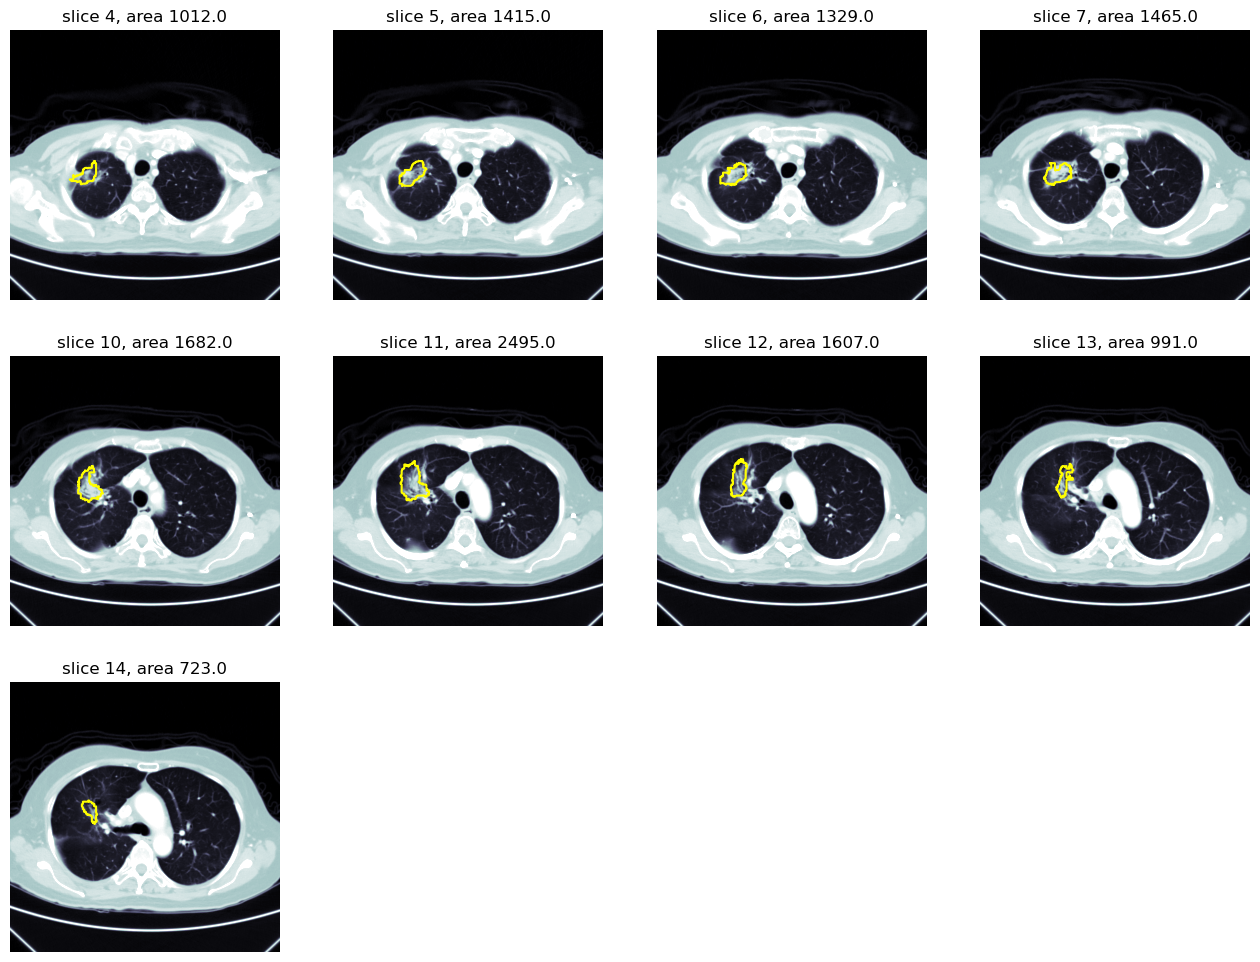

saved to NRRDs/000218422H_20191128.nrrd
saved to NRRDs/000218422H_20191128.seg.nrrd


In [28]:
msk = inference(
    weightPath='expA/0.0244_109.pth',
    patientDicomPath='RP-2019-46p111ct/000218422H_20191128', #'D:/irene2023_share/20230711/001163511D/1.2.840.113817.20230411120100.1200116351194.85938009287',
    savePathNRDD='NRRDs/000218422H_20191128')
